In [13]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = ts.get_k_data("601398", start="2018-01-01", end="2018-05-27")

In [4]:
data.head()

,date,open,close,high,low,volume,code
0,2018-01-02,5.928,5.918,6.119,5.851,5374662.0,601398
1,2018-01-03,5.918,5.899,6.052,5.861,3493611.0,601398
2,2018-01-04,5.918,5.813,5.918,5.803,4351365.0,601398
3,2018-01-05,5.832,5.822,5.851,5.803,2817842.0,601398
4,2018-01-08,5.832,5.813,5.841,5.784,2184876.0,601398


# MA值
Moving average，即移动平均线指标

## 计算方法

MA = (C1+C2+C3+C4+C5+....+Cn)/n （C 为收盘价答，n 为移动平均周期数）

## 实现代码

In [25]:
def ma(data, n=10, val_name="close"):
    '''
    移动平均线 Moving Average
    Parameters
    ------
      data:pandas.DataFrame
                  通过 get_h_data 取得的股票数据
      n:int
                  移动平均线时长，时间单位根据data决定
      val_name:string
                  计算哪一列的列名，默认为 close 收盘值

    return
    -------
      list
          移动平均线
    '''

    values = []
    MA = []

    for index, row in data.iterrows():
        values.append(row[val_name])
#         if len(values) == n:            此处有误
#             del values[0]
        MA.append(np.average(values))
        if len(values) == n:        
            del values[0]    

    return np.asarray(MA)

### 收盘前，当日的MA线是会移动的

# EMA值

Exponential Moving Average，指数移动平均值，以指数式递减加权的移动平均（时间越靠近当今，权重越大）

当要比较数值与均价的关系时，用 MA 就可以了，而要比较均价的趋势快慢时，用 EMA 更稳定

## 计算方法

In [39]:
%%latex
定义式
$$EMA_N(X_n)=\frac{2}{N+1}\sum_{k=0}^{\infty}(\frac{N-1}{N+1})^k x_{n-k}$$

推递式
$$EMA_N(X_n)=\frac{2x_n+(N-1)EMA_N(X_{n-1})}{N+1}$$

<IPython.core.display.Latex object>

## 实现代码

In [ ]:
def ema(data, n=12, val_name="close"):
    '''
        指数平均数指标 Exponential Moving Average
        Parameters
        ------
          data:pandas.DataFrame
                      通过 get_h_data 取得的股票数据
          n:int
                      移动平均线时长，时间单位根据data决定
          val_name:string
                      计算哪一列的列名，默认为 close 收盘值

        return
        -------
          EMA:numpy.ndarray<numpy.float64>
              指数平均数指标
    '''

    prices = []

    EMA = []

    for index, row in data.iterrows():
        if index == 0:
            past_ema = row[val_name]
            EMA.append(row[val_name])
        else:
            today_ema = (2 * row[val_name] + (n - 1) * past_ema) / (n + 1)
            past_ema = today_ema

            EMA.append(today_ema)

    return np.asarray(EMA)

# MACD指标
Moving Average Convergence / Divergence，异同移动平均线，是从双指数移动平均线发展而来的

## 计算方法

由快的指数移动平均线（EMA12）减去慢的指数移动平均线（EMA26）得到快线DIF，再用2×（快线DIF-DIF的9日加权移动均线DEA）得到MACD柱

## 实现代码

In [41]:
def macd(data, quick_n=12, slow_n=26, dem_n=9, val_name="close"):
    '''
        指数平滑异同平均线(MACD: Moving Average Convergence Divergence)
        Parameters
        ------
          data:pandas.DataFrame
                      通过 get_h_data 取得的股票数据
          quick_n:int
                      DIFF差离值中快速移动天数
          slow_n:int
                      DIFF差离值中慢速移动天数
          dem_n:int
                      DEM讯号线的移动天数
          val_name:string
                      计算哪一列的列名，默认为 close 收盘值

        return
        -------
          OSC:numpy.ndarray<numpy.float64>
              MACD bar / OSC 差值柱形图 DIFF - DEM
          DIFF:numpy.ndarray<numpy.float64>
              差离值
          DEM:numpy.ndarray<numpy.float64>
              讯号线
    '''

    ema_quick = np.asarray(ema(data, quick_n, val_name))
    ema_slow = np.asarray(ema(data, slow_n, val_name))
    DIFF = ema_quick - ema_slow
    data["diff"] = DIFF
    DEM = ema(data, dem_n, "diff")
    OSC = DIFF - DEM
    return 2*OSC

# KDJ指标
随机指标，根据统计学原理，通过一个特定的周期（常为9日、9周等）内出现过的最高价、最低价及最后一个计算周期的收盘价及这三者之间的比例关系，来计算最后一个计算周期的未成熟随机值RSV，然后根据平滑移动平均线的方法来计算K值、D值与J值

## 计算方法

n日RSV=（Cn－Ln）/（Hn－Ln）×100，其中Cn为第n日收盘价；Ln为n日内的最低价；Hn为n日内的最高价

其次，计算K值与D值：

当日K值=2/3×前一日K值+1/3×当日RSV

当日D值=2/3×前一日D值+1/3×当日K值

若无前一日K 值与D值，则可分别用50来代替。

J值=3*当日K值-2*当日D值

以9日为周期的KD线为例，即未成熟随机值

计算公式为9日RSV=（C－L9）÷（H9－L9）×100%，其中C为第9日的收盘价；L9为9日内的最低价；H9为9日内的最高价

K值=2/3×第8日K值+1/3×第9日RSV

D值=2/3×第8日D值+1/3×第9日K值

J值=3*第9日K值-2*第9日D值

若无前一日K值与D值，则可以分别用50代替

## 实现代码

In [40]:
def kdj(data):
    '''
        随机指标KDJ
        Parameters
        ------
          data:pandas.DataFrame
                通过 get_h_data 取得的股票数据
        return
        -------
          K:numpy.ndarray<numpy.float64>
              K线
          D:numpy.ndarray<numpy.float64>
              D线
          J:numpy.ndarray<numpy.float64>
              J线
    '''

    K, D, J = [], [], []
    last_k, last_d = None, None
    for index, row in data.iterrows():
        if last_k is None or last_d is None:
            last_k = 50
            last_d = 50

        c, l, h = row["close"], row["low"], row["high"]

        rsv = (c - l) / (h - l) * 100

        k = (2 / 3) * last_k + (1 / 3) * rsv
        d = (2 / 3) * last_d + (1 / 3) * k
        j = 3 * k - 2 * d

        K.append(k)
        D.append(d)
        J.append(j)

        last_k, last_d = k, d

    return np.asarray(K), np.asarray(D), np.asarray(J)

# RSI指标

## 实现代码

In [42]:
def rsi(data, n=6, val_name="close"):
    import numpy as np

    '''
        相对强弱指标RSI
        Parameters
        ------
          data:pandas.DataFrame
                      通过 get_h_data 取得的股票数据
          n:int
                统计时长，时间单位根据data决定
        return
        -------
          RSI:numpy.ndarray<numpy.float64>
              RSI线
        
    '''

    RSI = []
    UP = []
    DOWN = []
    for index, row in data.iterrows():
        if index == 0:
            past_value = row[val_name]
            RSI.append(0)
        else:
            diff = row[val_name] - past_value
            if diff > 0:
                UP.append(diff)
                DOWN.append(0)
            else:
                UP.append(0)
                DOWN.append(diff)

            if len(UP) == n:
                del UP[0]
            if len(DOWN) == n:
                del DOWN[0]

            past_value = row[val_name]

            rsi = np.sum(UP) / (-np.sum(DOWN) + np.sum(UP)) * 100
            RSI.append(rsi)

    return np.asarray(RSI)

# bool指标

## 实现代码

In [43]:
def boll(data, n=10, val_name="close", k=2):
    '''
        布林线指标BOLL
        Parameters
        ------
          data:pandas.DataFrame
                      通过 get_h_data 取得的股票数据
          n:int
                统计时长，时间单位根据data决定
        return
        -------
          BOLL:numpy.ndarray<numpy.float64>
              中轨线
          UPPER:numpy.ndarray<numpy.float64>
              D线
          J:numpy.ndarray<numpy.float64>
              J线
    '''

    BOLL = ma(data, n, val_name)

    MD = md(data, n, val_name)

    UPPER = BOLL + k * MD

    LOWER = BOLL - k * MD

    return BOLL, UPPER, LOWER

# 画K线图

In [6]:
import datetime
import pandas_datareader.data as web
import mpl_finance as mpf  
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_stockload = web.DataReader("600797.SS", "yahoo", datetime.datetime(2018, 1, 1), datetime.datetime(2019, 1, 1))
df_stockload.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2018-01-02 to 2018-12-28
Data columns (total 6 columns):
High         243 non-null float64
Low          243 non-null float64
Open         243 non-null float64
Close        243 non-null float64
Volume       243 non-null float64
Adj Close    243 non-null float64
dtypes: float64(6)
memory usage: 13.3 KB


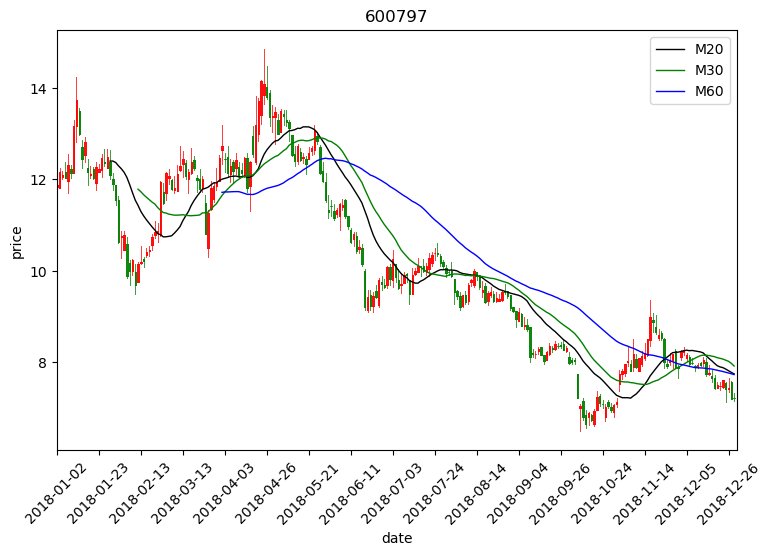

In [11]:
# 创建fig对象
fig = plt.figure(figsize=(8, 6), dpi=100, facecolor="white")

# 设置图像边框
fig.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)

# 创建子图
graph_KAV = fig.add_subplot(1, 1, 1)

# 画k线
mpf.candlestick2_ochl(graph_KAV, df_stockload.Open, df_stockload.Close, df_stockload.High, df_stockload.Low, width=0.5,colorup='r', colordown='g') 

# 绘制移动平均线图
df_stockload['Ma20'] = df_stockload.Close.rolling(window=20).mean()
df_stockload['Ma30'] = df_stockload.Close.rolling(window=30).mean()
df_stockload['Ma60'] = df_stockload.Close.rolling(window=60).mean()

# 绘制到图上面
graph_KAV.plot(np.arange(0, len(df_stockload.index)), df_stockload['Ma20'], 'black', label='M20', lw=1.0)
graph_KAV.plot(np.arange(0, len(df_stockload.index)), df_stockload['Ma30'], 'green', label='M30', lw=1.0)
graph_KAV.plot(np.arange(0, len(df_stockload.index)), df_stockload['Ma60'], 'blue', label='M60', lw=1.0)

# 图像设置

# 添加图例
graph_KAV.legend(loc='best')

graph_KAV.set_title("600797")
graph_KAV.set_xlabel("date")
graph_KAV.set_ylabel("price")
graph_KAV.set_xlim(0, len(df_stockload.index))  # 设置一下x轴的范围
graph_KAV.set_xticks(range(0, len(df_stockload.index), 15))  # X轴刻度设定 每15天标一个日期
graph_KAV.set_xticklabels([df_stockload.index.strftime('%Y-%m-%d')[index] for index in graph_KAV.get_xticks()])  # 标签设置为日期

# X-轴每个ticker标签都向右倾斜45度
for label in graph_KAV.xaxis.get_ticklabels():
    label.set_rotation(45)
    label.set_fontsize(10)  # 设置标签字体
plt.show()